# Kupffer Cell Culture RNA Seq Data Processing

In [12]:
### header ###
__author__ = "Hunter Bennett"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['figure.figsize'] = 4, 4
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [13]:
workingDirectory = '/home/h1bennet/liverStrains/results/180511_KCCult_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### RNA QC
_____
Requires tag directories

In [14]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [19]:
# make summary table of qc stats
qc_stats = pd.DataFrame()
for sample in os.listdir('./tag_directories_rna/'):
    print(sample)
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                            qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                            / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                                    - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                                    - qc_stats.loc[sample, 'totalReads']
        else:
            qc_stats.loc[sample, 'totalReads'] =np.nan
            qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
            qc_stats.loc[sample, 'multiMappedReads'] = np.nan
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
            qc_stats.loc[sample, 'mappedFraction'] = np.nan
    
qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

balbcj_Kupffer_RNA_polyA_1WkCultDMGHep24h_JSSTDTCMBHB_Balb16A_CMB_l20180430
balbcj_Kupffer_RNA_polyA_1WkCultKLA24h_JSSTDTCMBHB_Balb16B_CMB_l20180430_combined
balbcj_Kupffer_RNA_polyA_1WkCultKLA24h_JSSTDTCMBHB_Balb16B_CMB_l20180430
C57_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_C575A_CMB_l20180228
balbcj_Kupffer_RNA_polyA_1WkCultT091uM_JSSTDTCMBHB_Balb16A_CMB_l20180430
balbc_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_Balb16B_CMB_l20180228
balbcj_Kupffer_RNA_polyA_1WkCultKLA24h_JSSTDTCMBHB_Balb16A_CMB_l20180430
balbcj_Kupffer_RNA_polyA_1WkCultDMGHep24h_JSSTDTCMBHB_Balb16B_CMB_l20180430
balbcj_Kupffer_RNA_polyA_1WkCultKLA6h_JSSTDTCMBHB_Balb16B_CMB_l20180430
balbc_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_Balb16A_CMB_l20180228
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575A_CMB_l20180430_combined
balbcj_Kupffer_RNA_polyA_1WkCultDMGHep4h_JSSTDTCMBHB_Balb16A_CMB_l20180430
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575A_CMB_l20180430
balbcj_Kupffer_RNA_polyA_1WkCultKLA6h_JSSTDTCMBHB_Ba

In [20]:
qc_stats

,uniquePositions,fragmentLengthEstimate,tagsPerBP,clonality,GC_Content,totalReads,uniquelyMappedReads,multiMappedReads,frac_unmappedReads_mismatch,frac_unmappedReads_short,frac_unmappedReads_other,uniquelyMappedFraction,mappedFraction
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575A_CMB_l20180430,1580014.0,75.0,0.003300,5.684,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575A_CMB_l20180430_combined,1989321.0,75.0,0.009839,13.464,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575A_CMB_l20180430_reseq,1825734.0,75.0,0.006539,9.750,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_C575B_CMB_l20180430,115498.0,75.0,0.001978,46.573,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_C575A_CMB_l20180228,616929.0,75.0,0.001984,8.751,0.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_C575B_CMB_l20180228,600662.0,75.0,0.003096,14.026,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aj_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_AJ16A_CMB_l20180430,145937.0,75.0,0.001516,28.239,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aj_Kupffer_RNA_polyA_1WkCult_JSSTDTCMBHB_AJ16B_CMB_l20180430,373156.0,75.0,0.001991,14.514,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aj_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_AJ16A_CMB_l20180228,4159689.0,75.0,0.004057,2.654,0.488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aj_Kupffer_RNA_polyA_1WkTranswellCultLSEC_HBCMB_AJ16B_CMB_l20180228,3379320.0,75.0,0.003716,2.992,0.479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
# make plots - set seaborn factors
sns.set_style('whitegrid')
sns.set_context('poster')

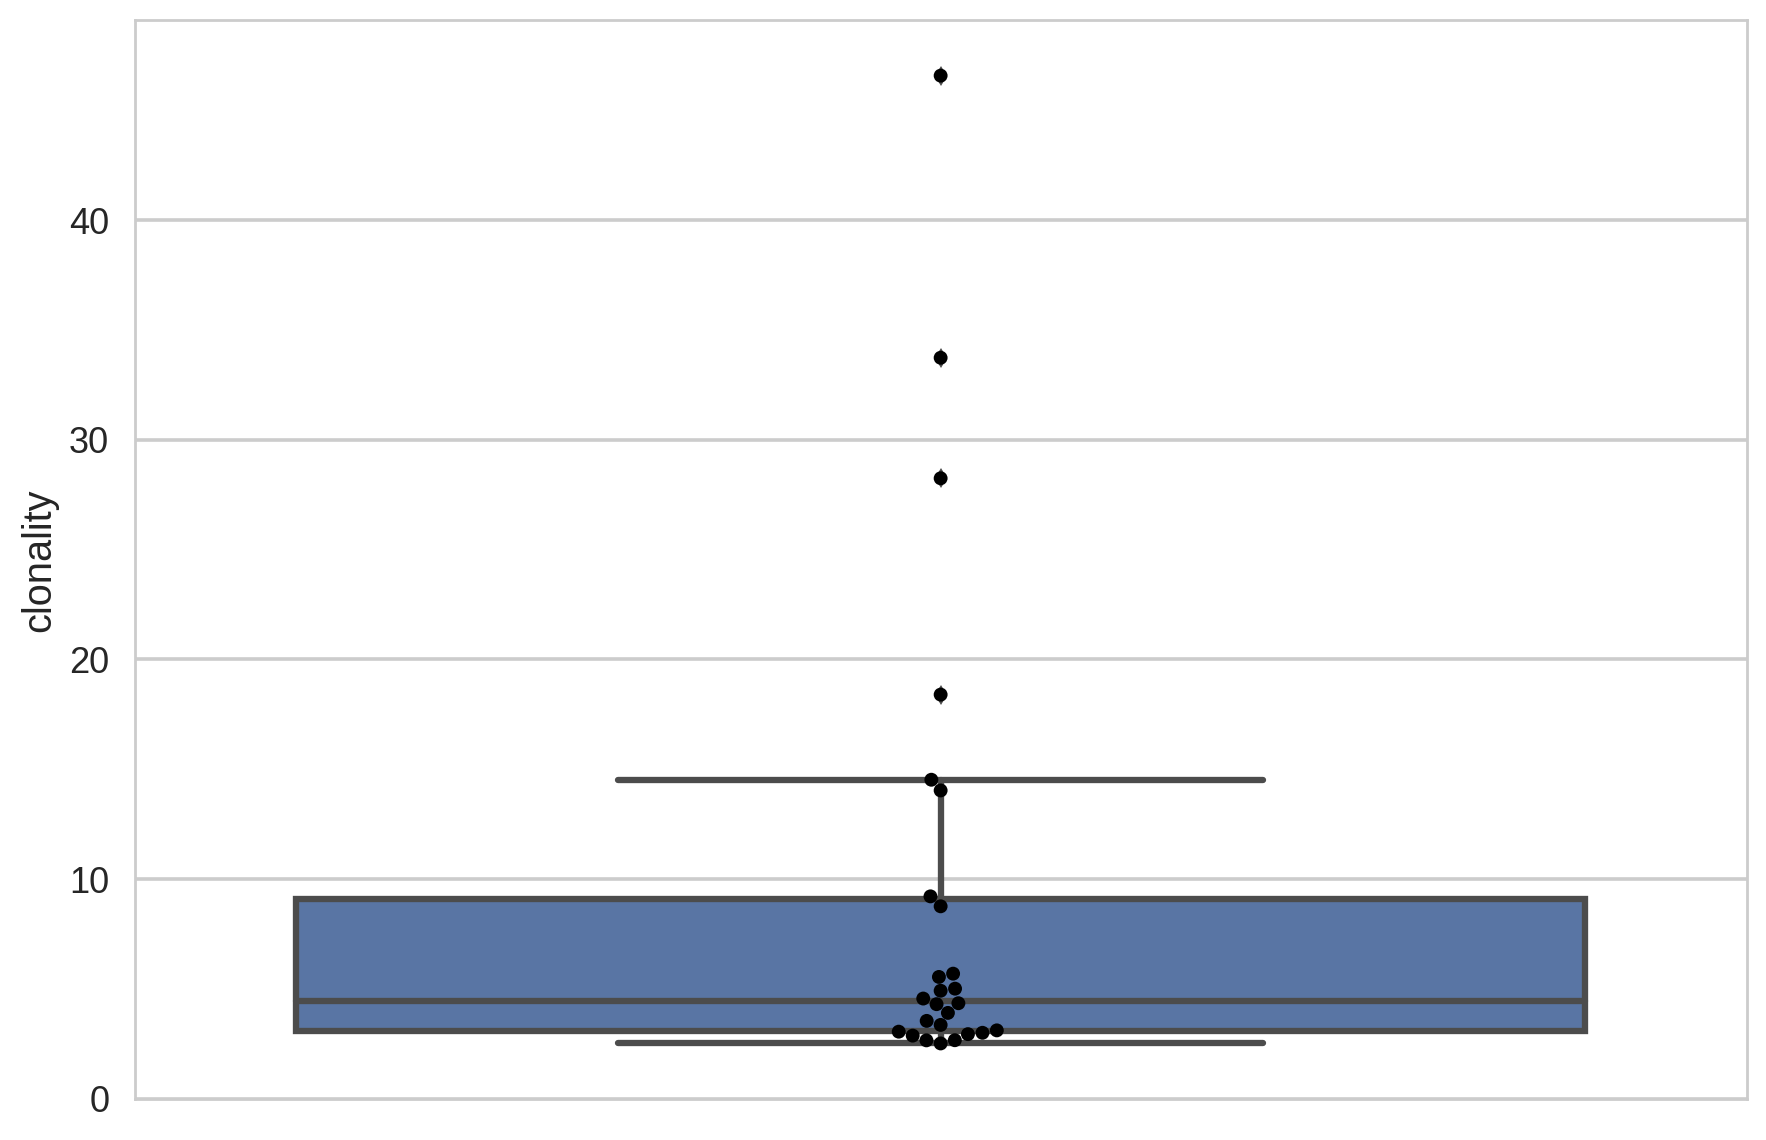

In [128]:
# clonality boxplot
fig = sns.boxplot(y=qc_stats['clonality']).get_figure()
fig = sns.swarmplot(y=qc_stats['clonality'], color='k').get_figure()
fig.savefig('./qc_rna/clonality_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


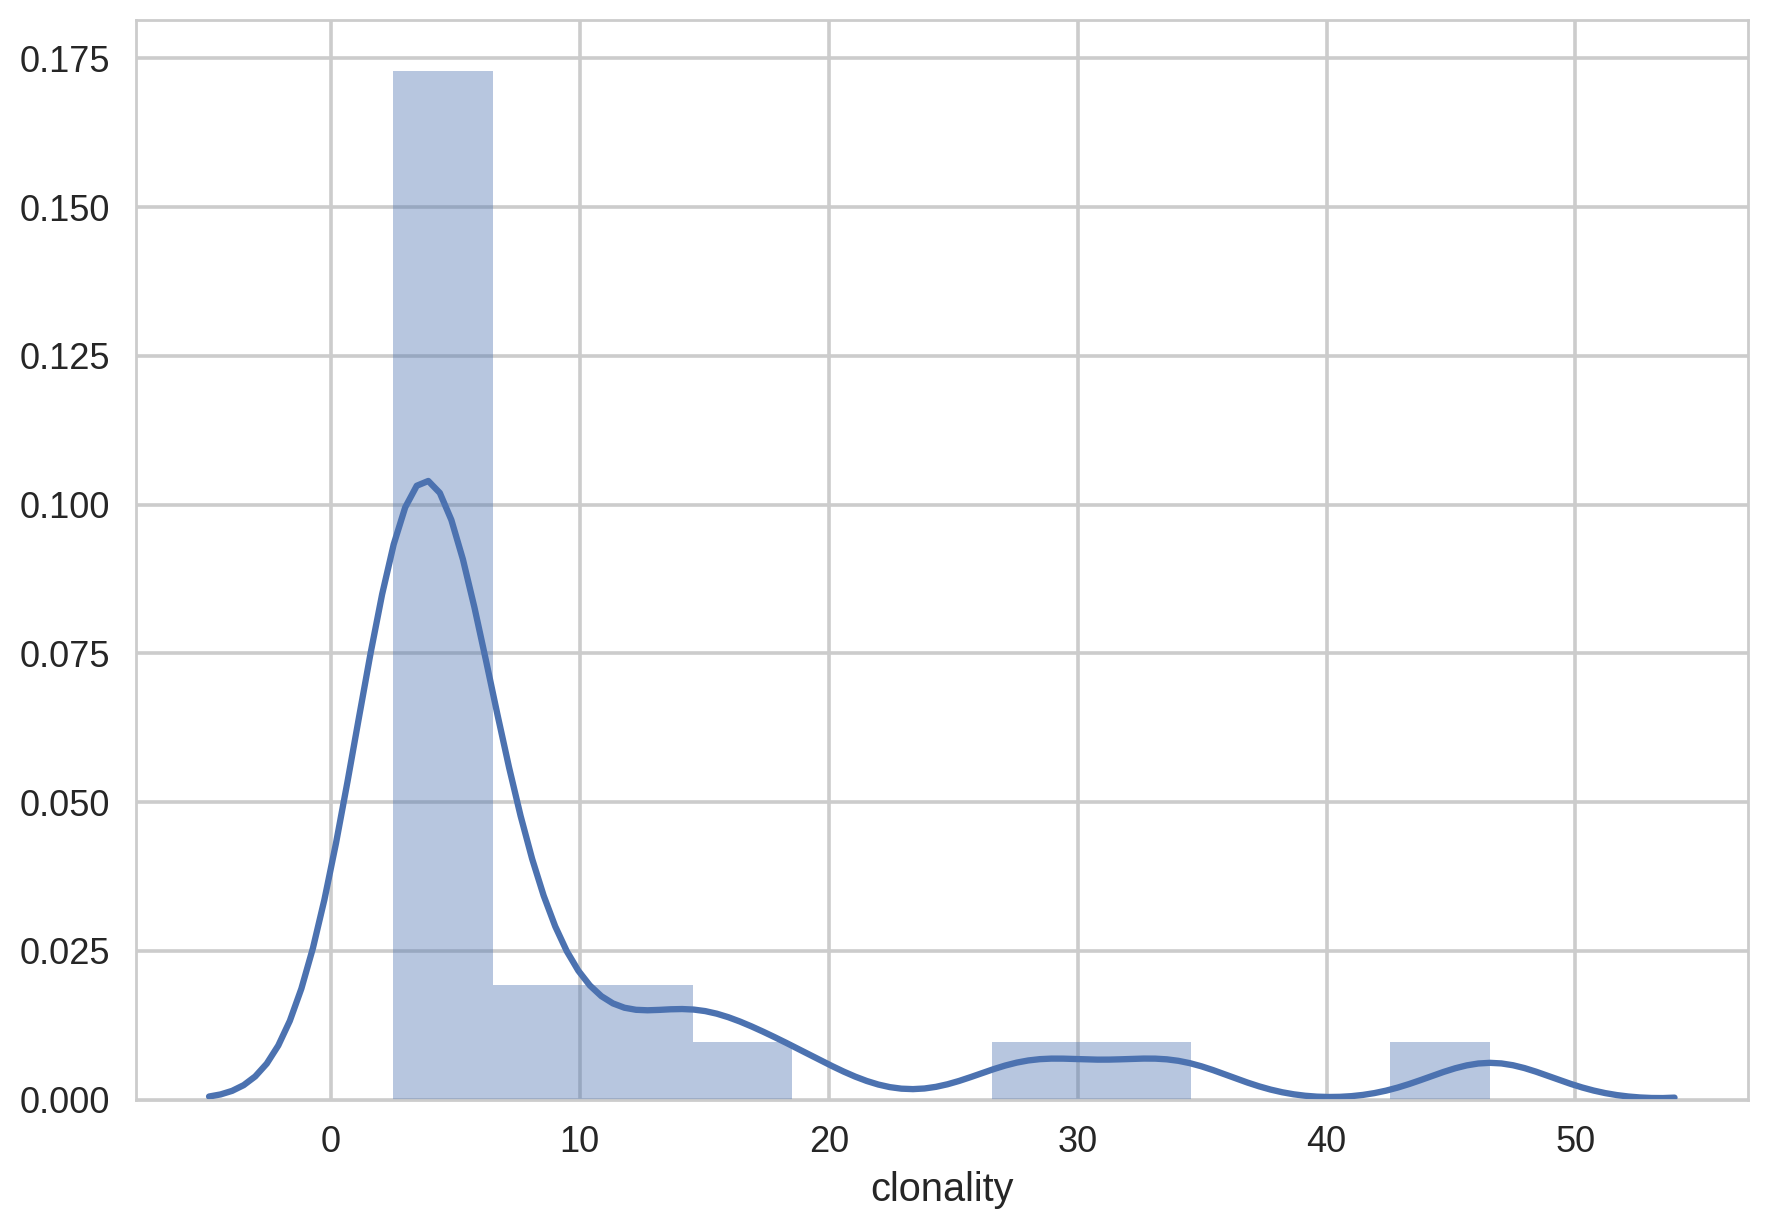

In [118]:
# clonality distplot
fig = sns.distplot(qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna/clonality_distplot_hb.pdf', bbox_inches='tight')

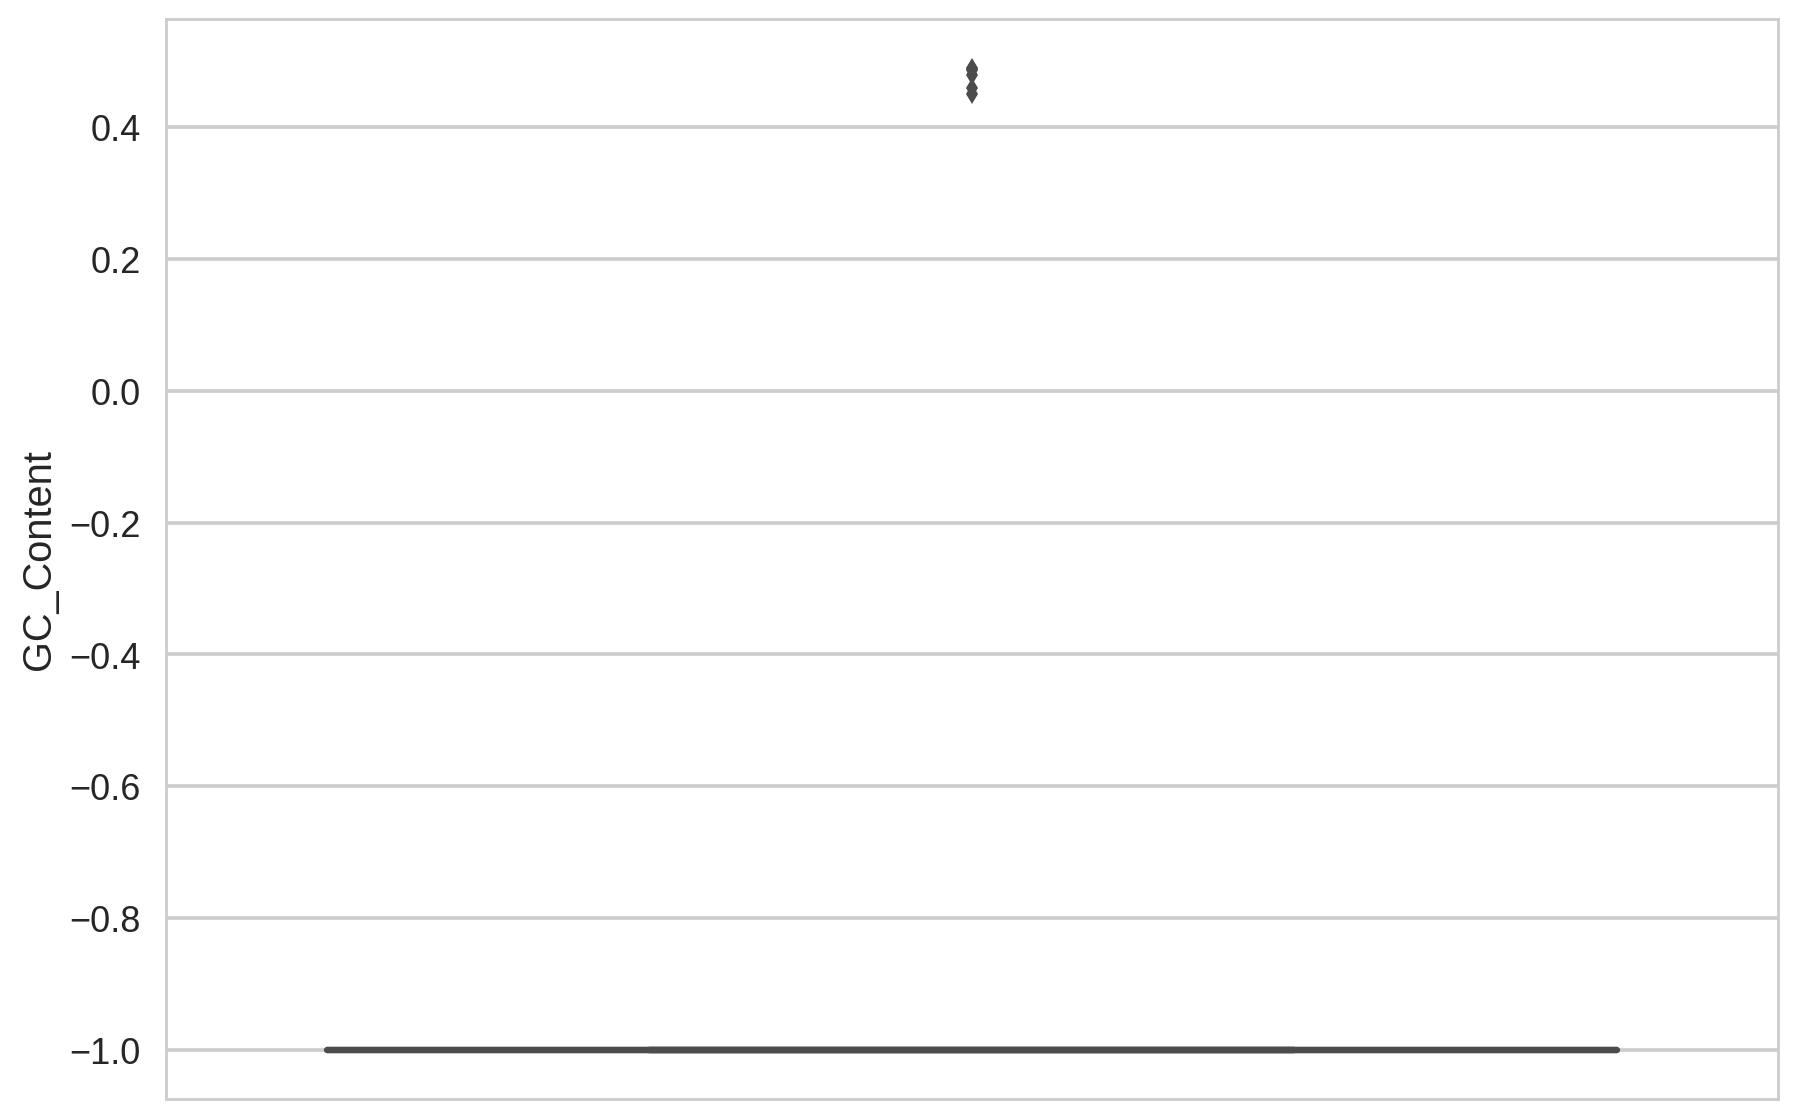

In [120]:
# GC_Content boxplot
fig = sns.boxplot(y=qc_stats['GC_Content']).get_figure()
fig.savefig('./qc_rna/GC_Content_boxplot_hb.pdf', bbox_inches='tight')

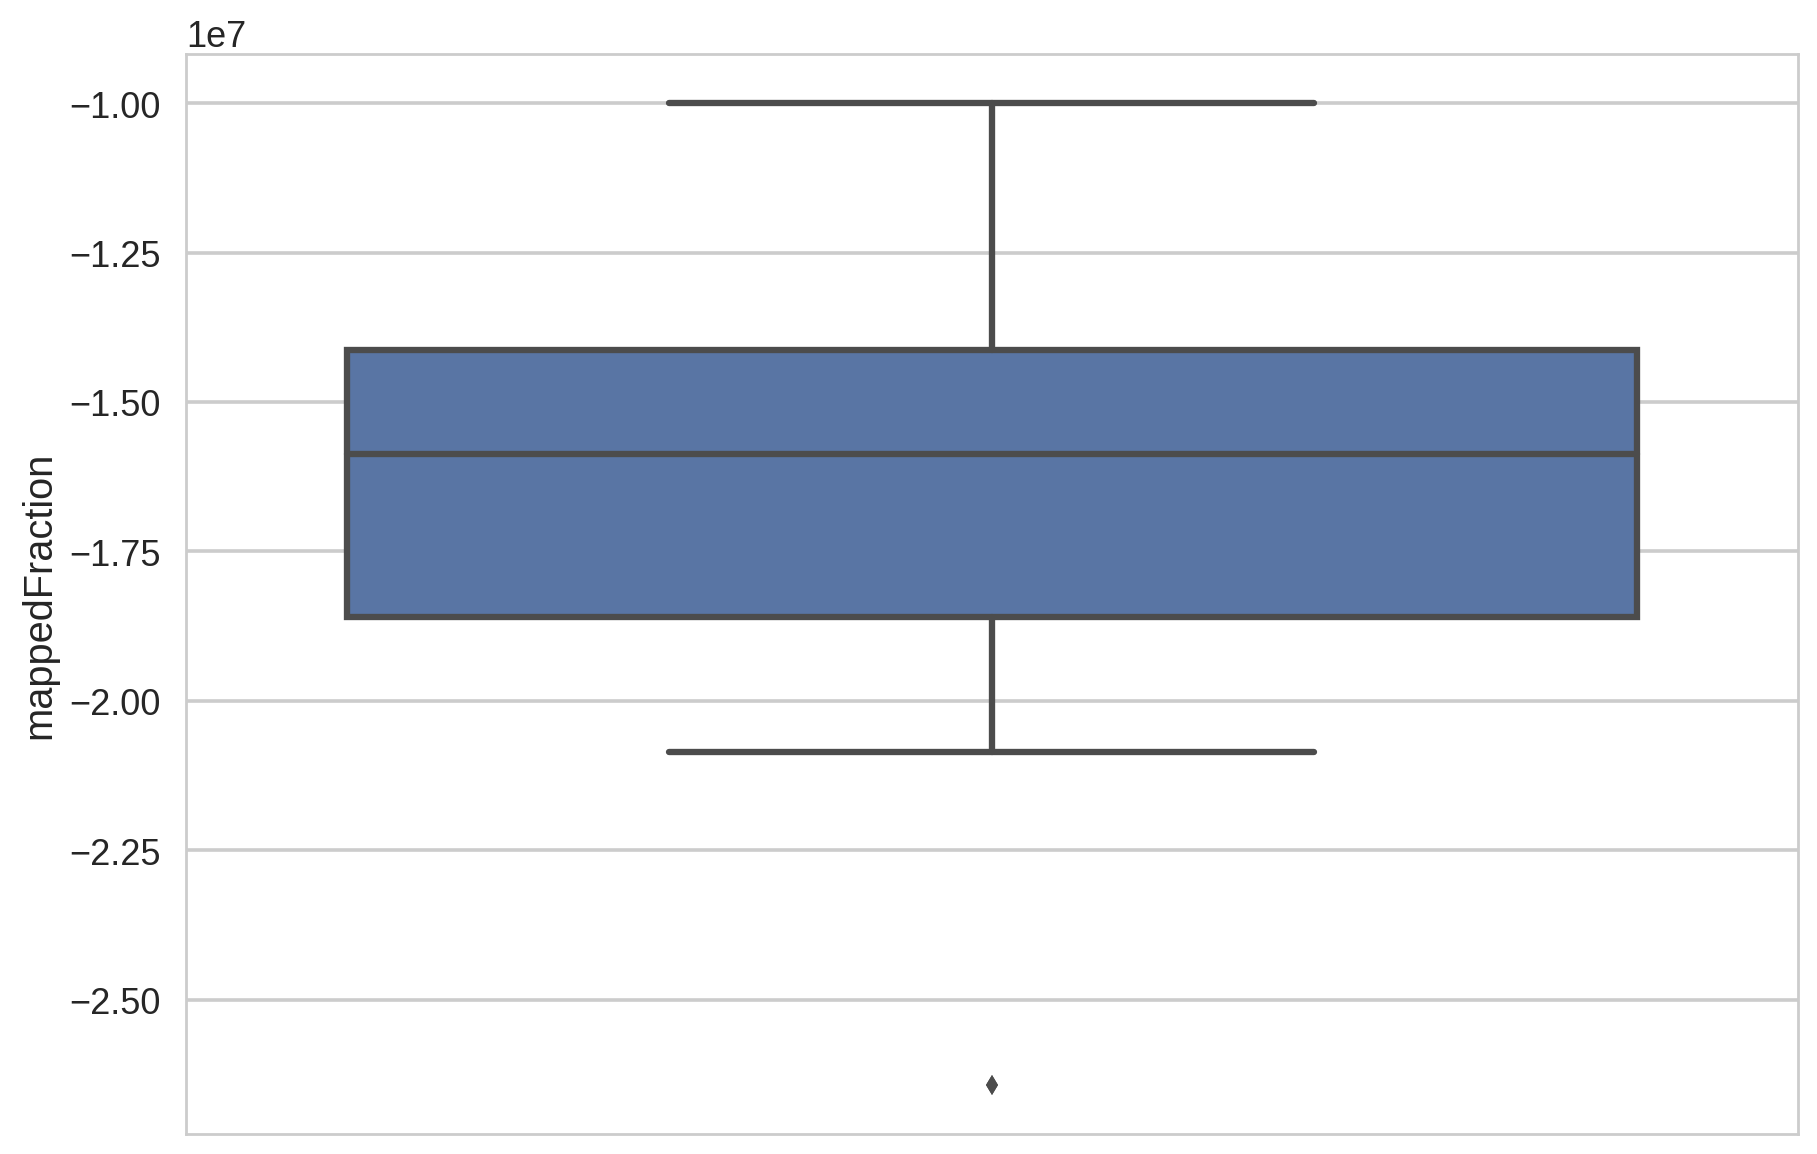

In [121]:
# mapped fraction boxplot
fig = sns.boxplot(y=qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_rna/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


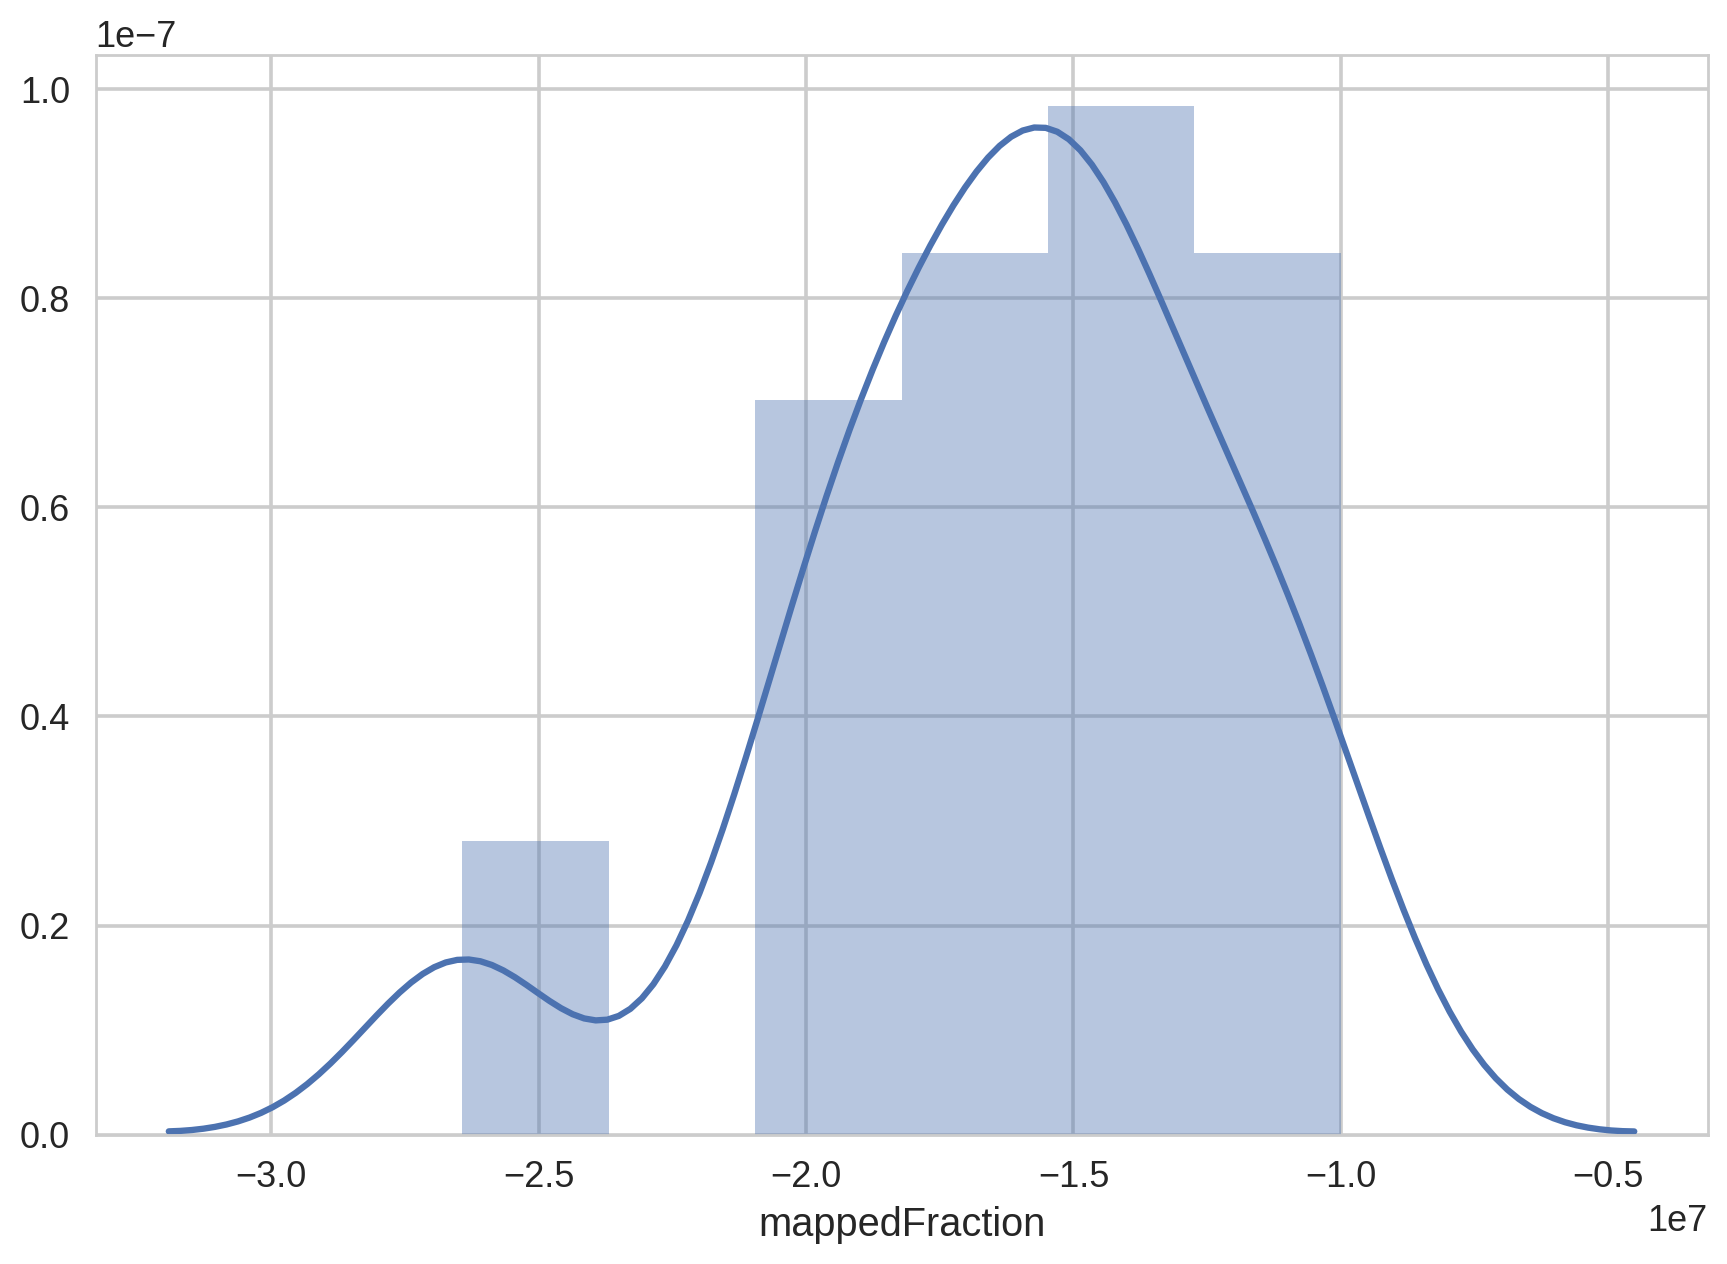

In [122]:
# mapped fraction distplot
fig = sns.distplot(qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_rna/mappedFraction_distplot_hb.pdf', bbox_inches='tight')

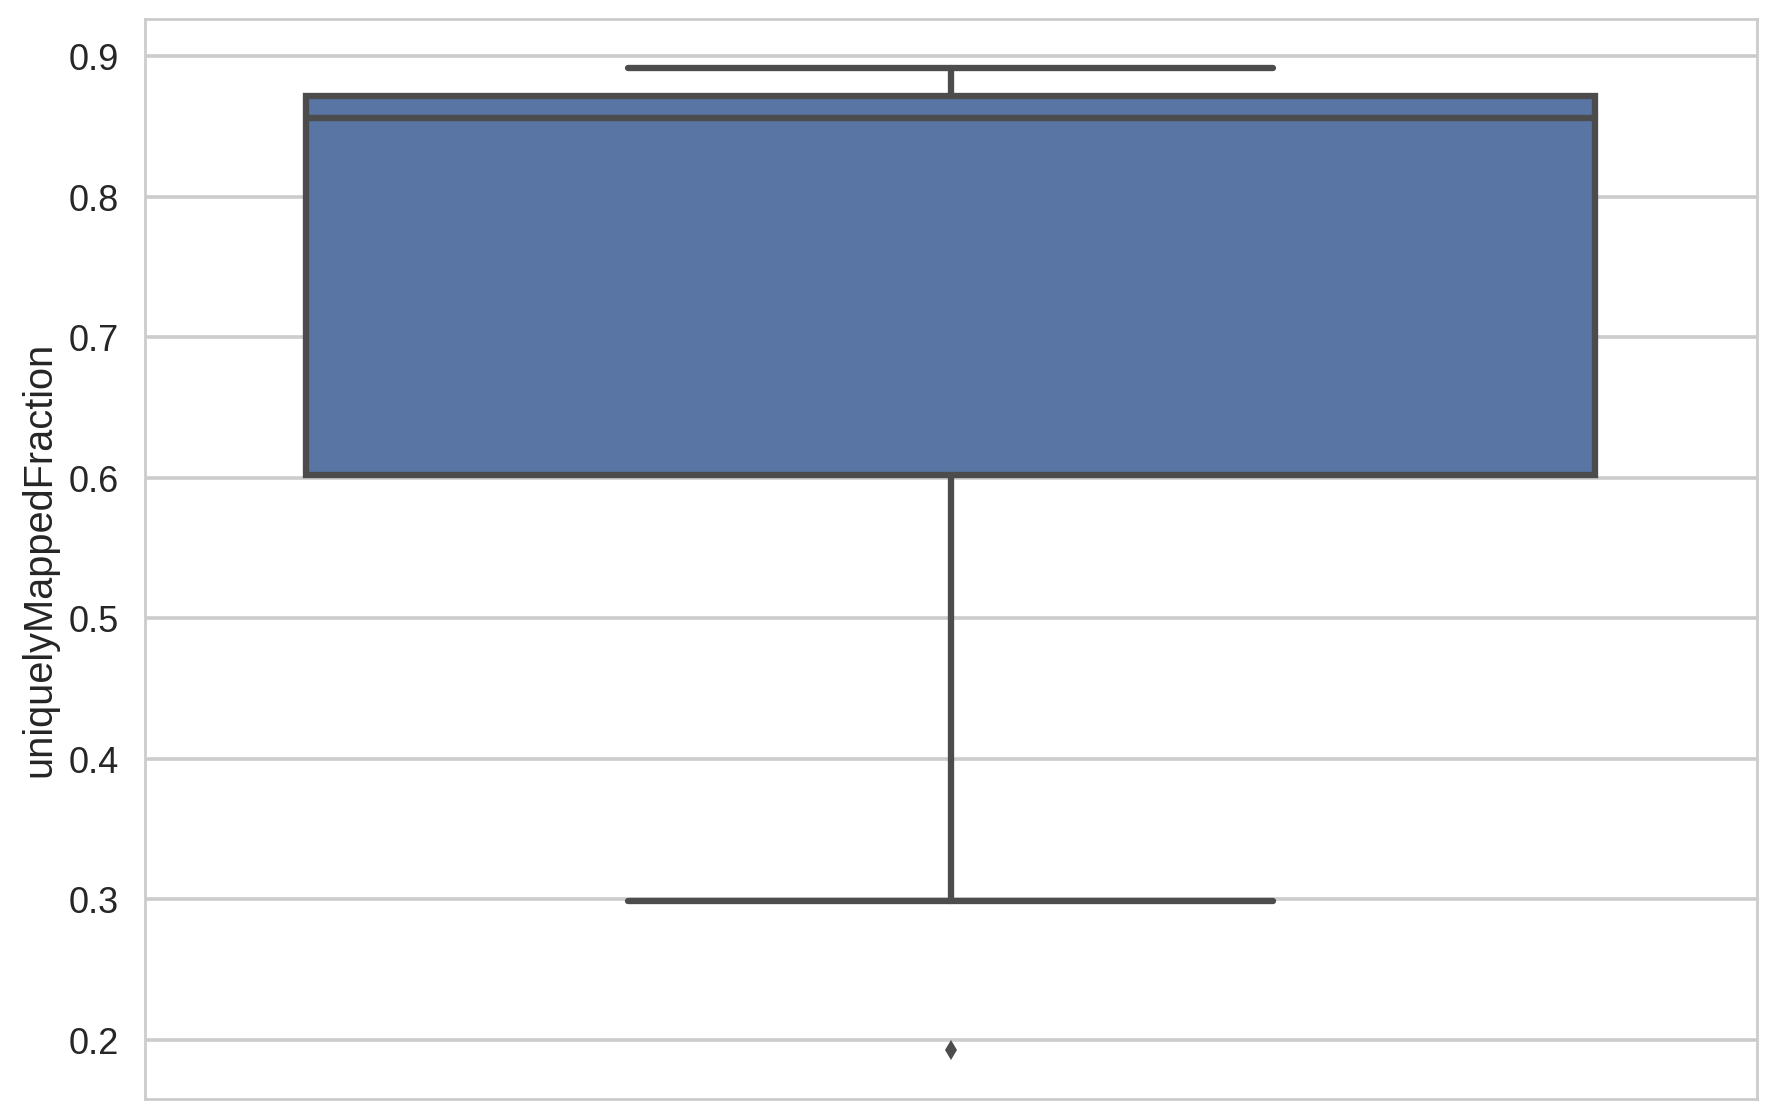

In [123]:
# uniquely Mapped Fraction boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction']).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


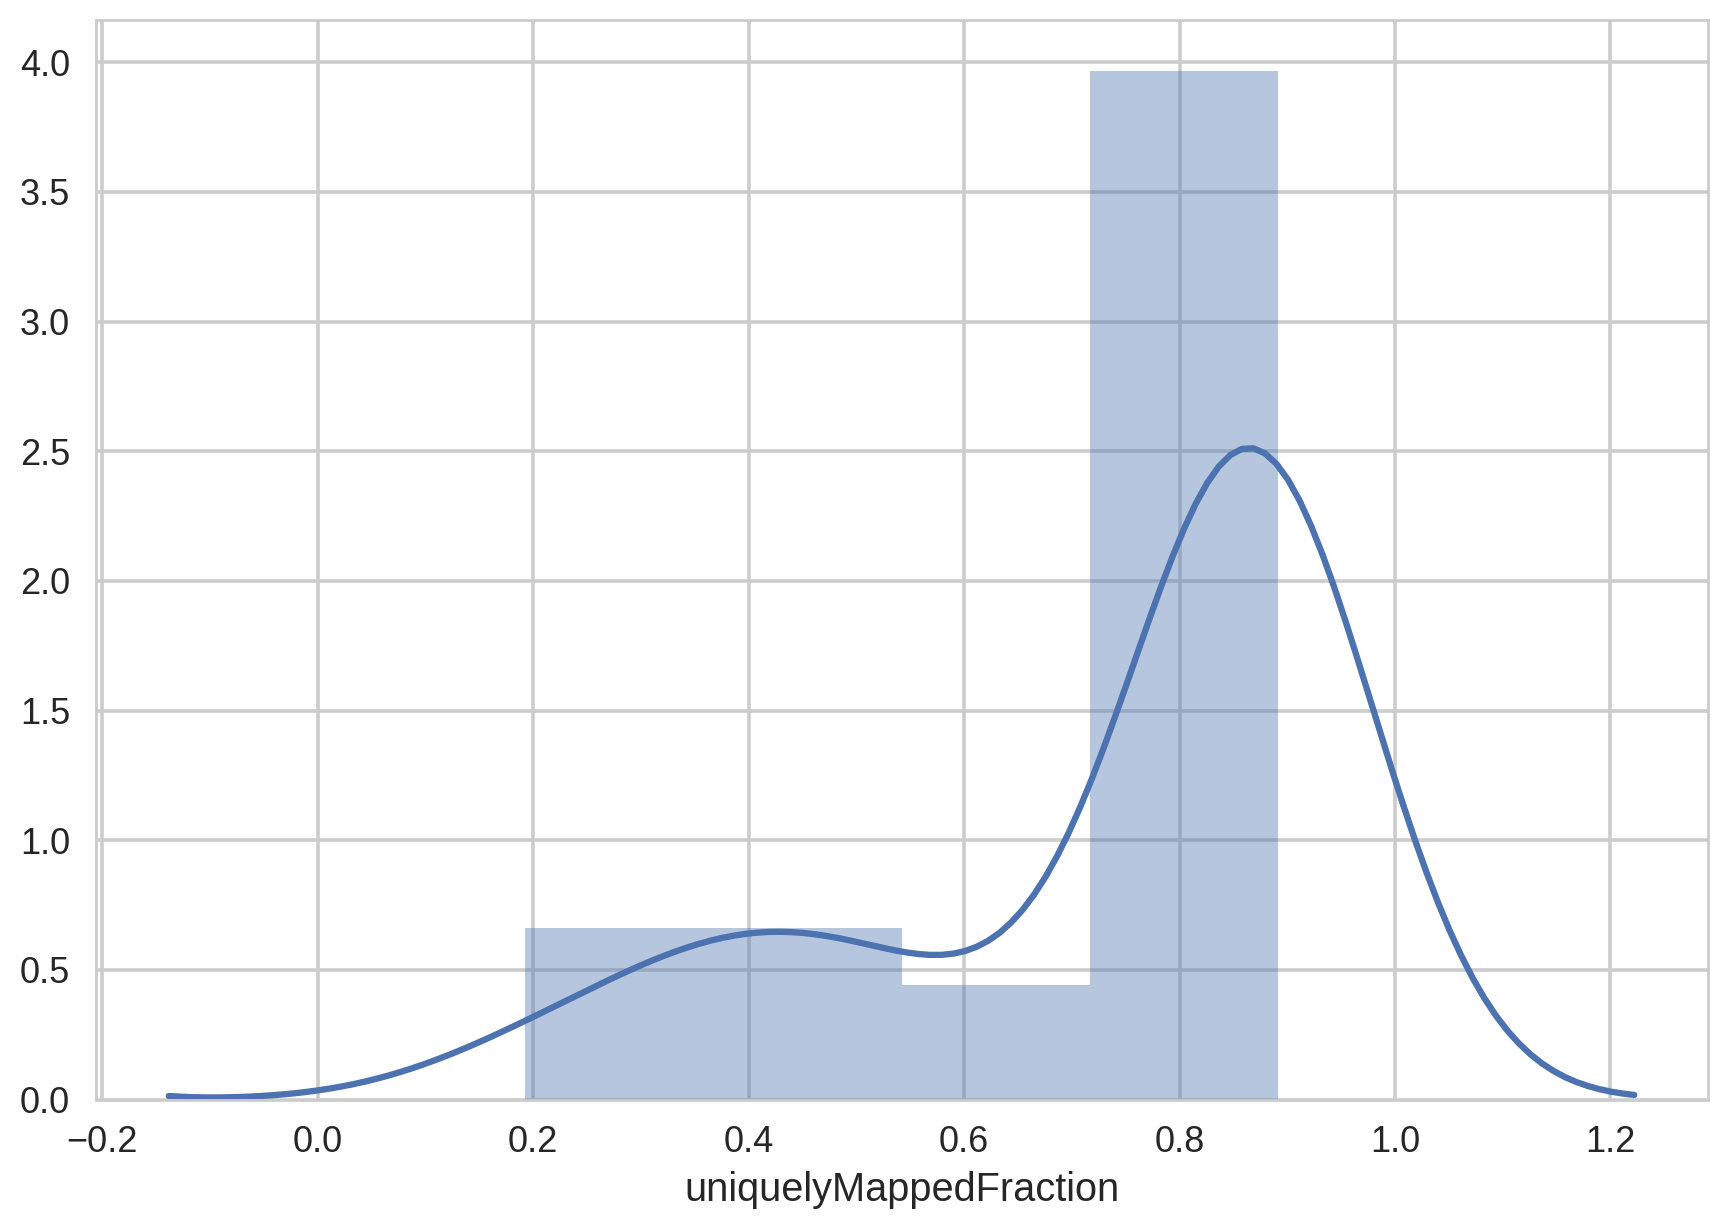

In [124]:
# uniquely Mapped Fraction distplot
fig = sns.distplot(qc_stats['uniquelyMappedFraction']).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')

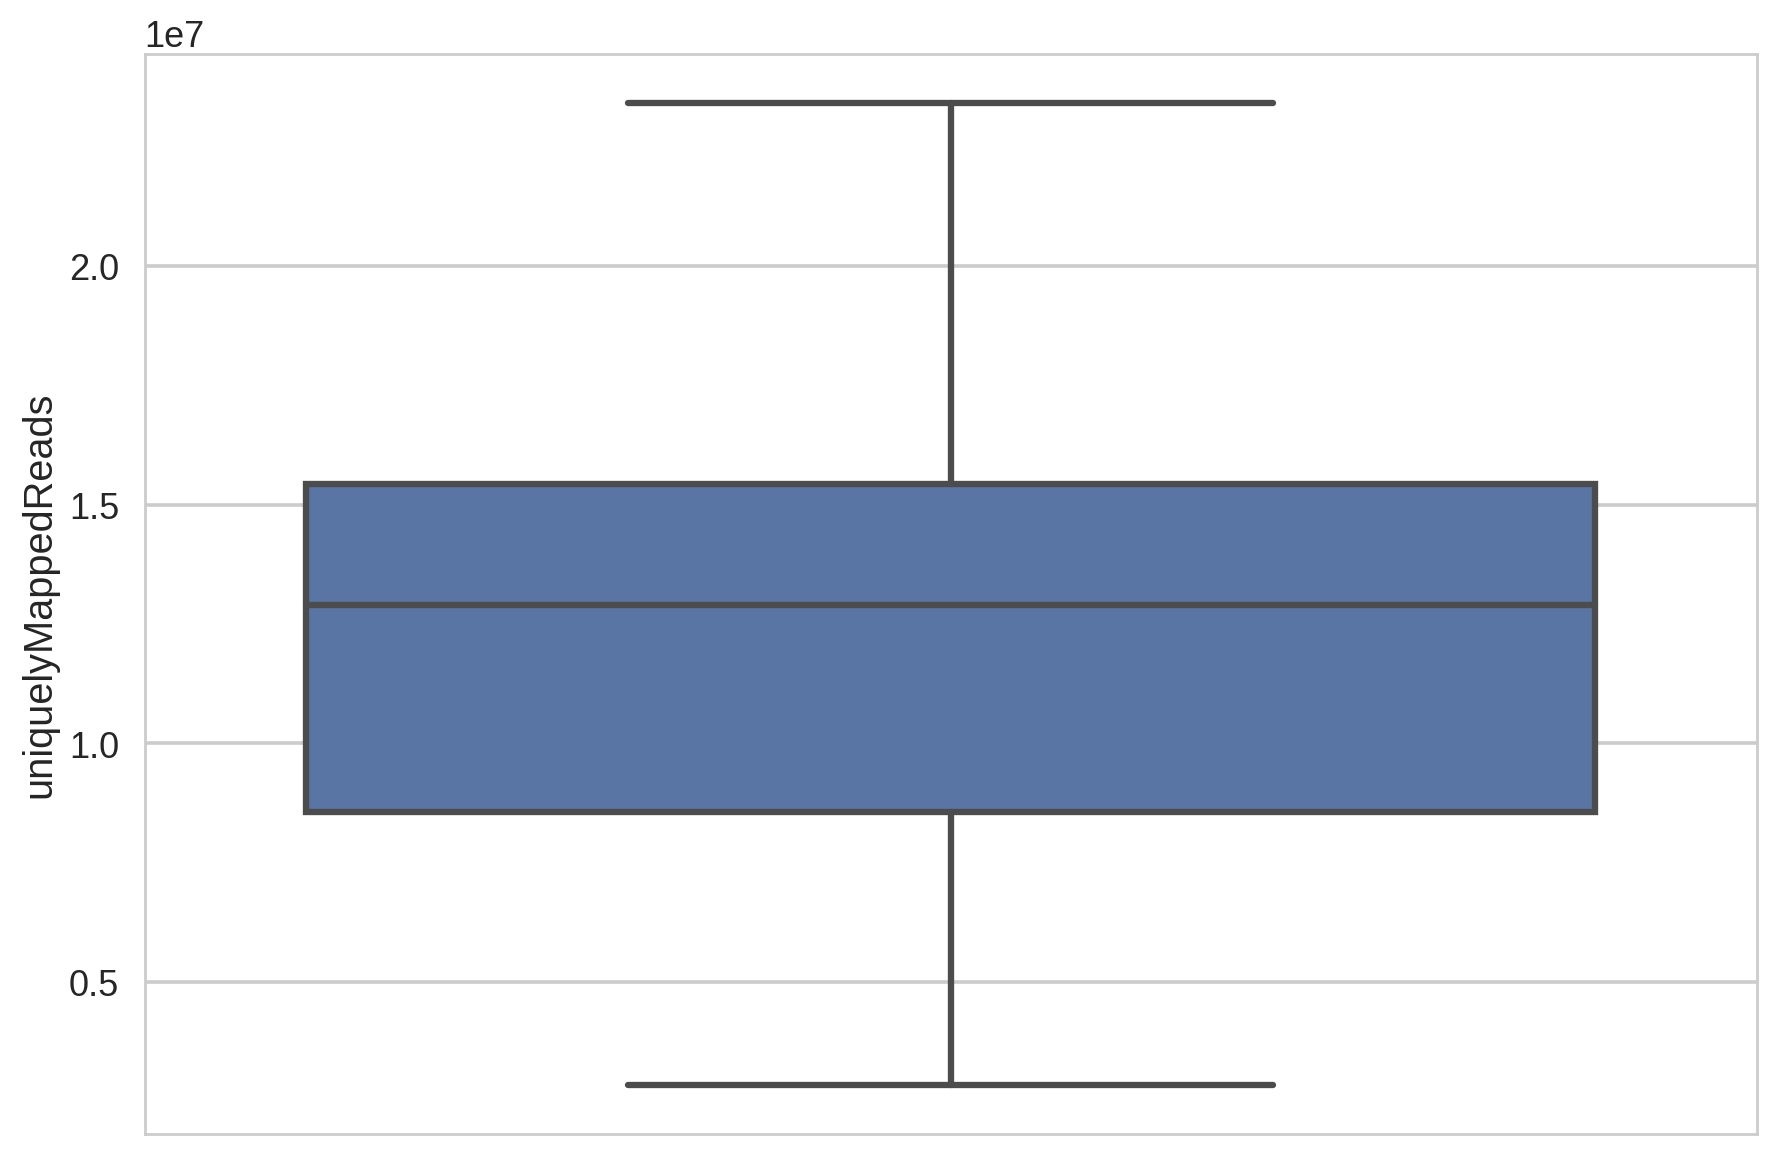

In [125]:
# uniquely Mapped Reads boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedReads']).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')
# uniquely Mapped Reads distplot

/home/h1bennet/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


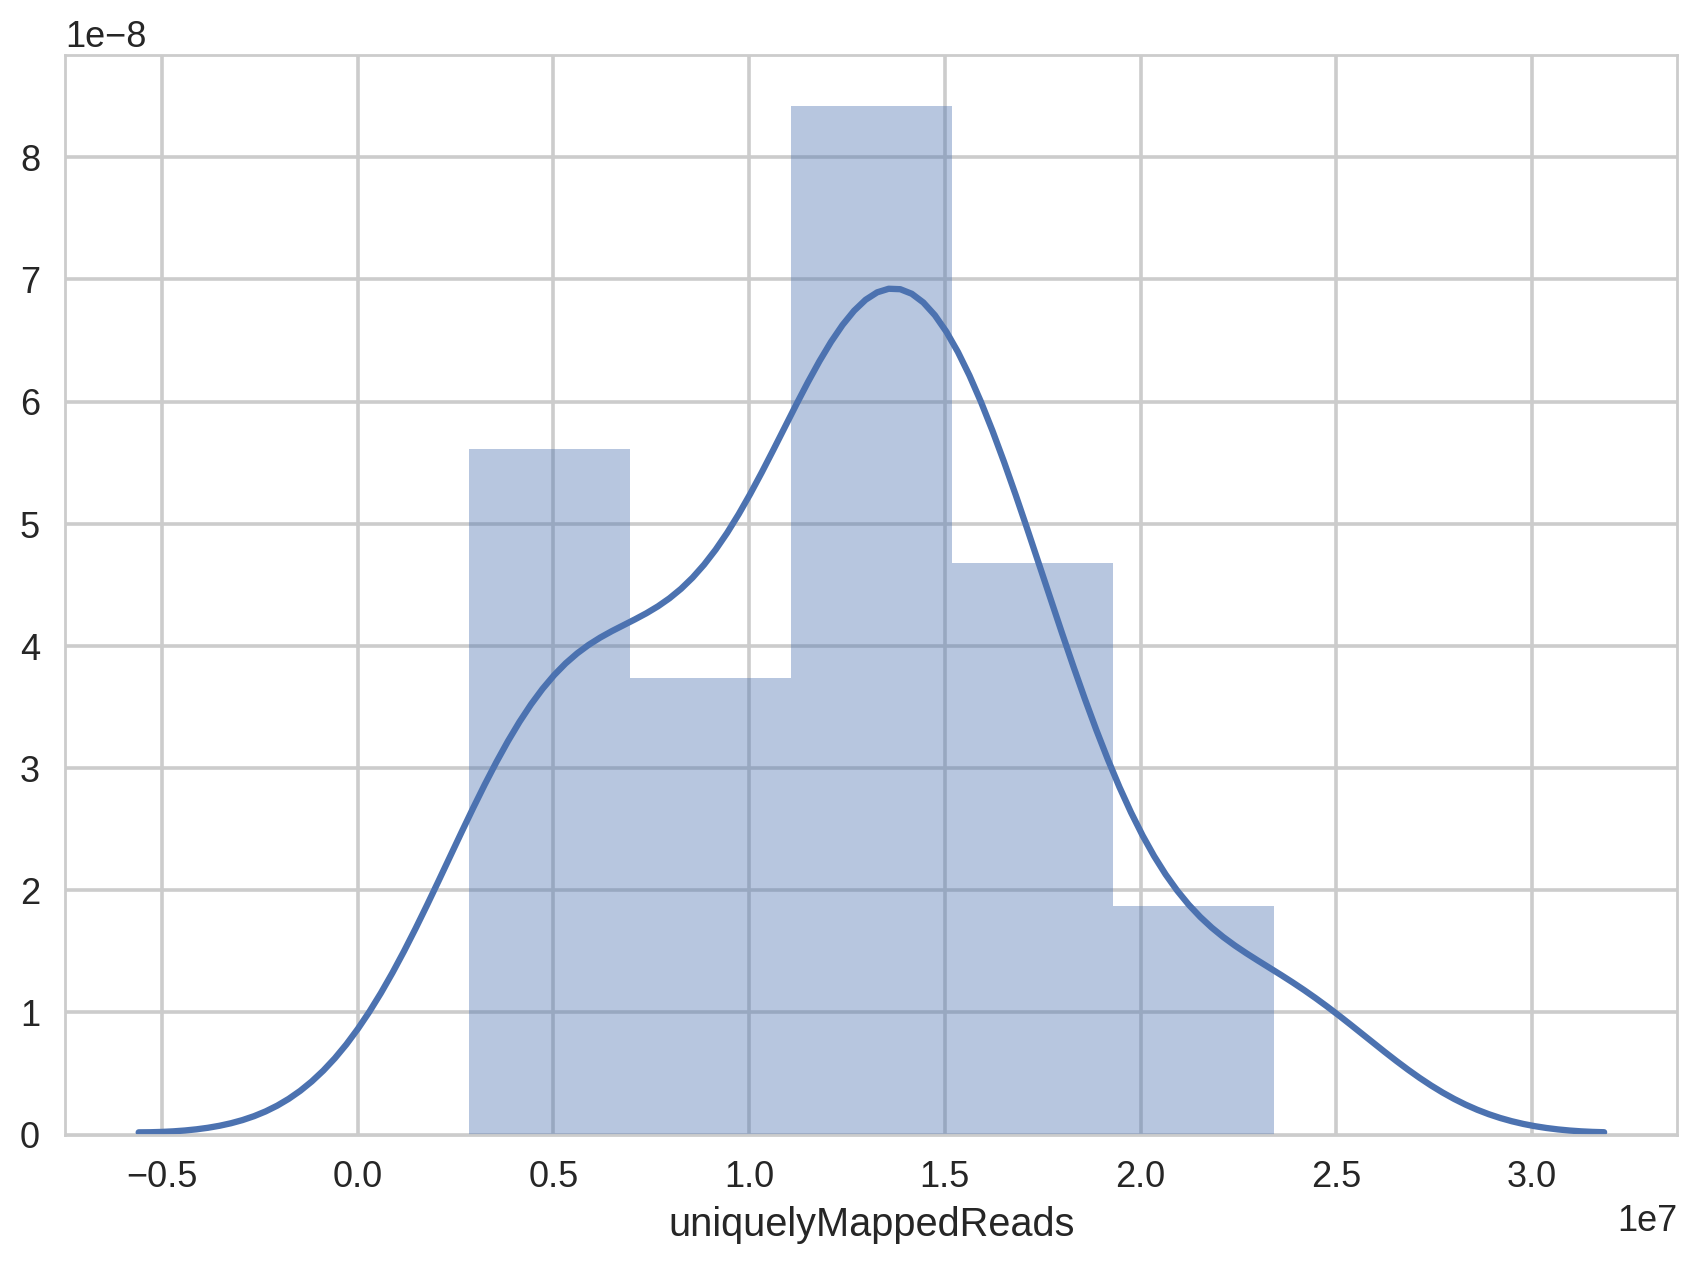

In [126]:
# uniquely Mapped Reads distplot
fig = sns.distplot(qc_stats['uniquelyMappedReads']).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')